# Predição de Mortalidade Infantil em Alagoas (2022-2025)

## Introdução

Este notebook apresenta um estudo completo para modelagem preditiva da mortalidade infantil nos municípios do estado de Alagoas, utilizando dados do ano de 2022. O objetivo principal é construir um modelo que permita identificar fatores associados ao risco de óbito infantil e prever a probabilidade de mortalidade para cenários futuros, especificamente para o ano de 2025.

## Objetivos

- Analisar os dados de nascimentos e óbitos infantis de Alagoas em 2022.
- Construir um modelo preditivo robusto para classificar municípios segundo o risco de mortalidade infantil.
- Aplicar técnicas de balanceamento para lidar com o desbalanceamento natural dos dados.
- Avaliar o desempenho do modelo utilizando métricas completas e validação cruzada.
- Criar uma simulação interativa para explorar previsões de mortalidade infantil ajustando variáveis demográficas e socioeconômicas.

## Metodologia

O pipeline envolve:

- Pré-processamento e agregação dos dados por município.
- Engenharia de features categóricas e numéricas.
- Balanceamento de classes com SMOTE.
- Treinamento e otimização de um Random Forest Classifier.
- Avaliação do modelo com métricas padrão e validação cruzada.
- Visualização interativa para cenários hipotéticos futuros.

## Impacto

Modelos preditivos como este auxiliam gestores públicos a direcionar recursos de saúde e intervenções sociais de forma mais eficiente, contribuindo para a redução da mortalidade infantil e melhoria da qualidade de vida na população.

---

Links das bases de dados:

Natalidade: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sinasc/cnv/nval.def

Mortalidade: https://opendatasus.saude.gov.br/dataset/sim/resource/9ade641a-1f25-40d9-b55b-cff7096eb5b4?

In [10]:
!pip install dbfread

In [68]:
# 1. Importar bibliotecas
import pandas as pd
import zipfile
import os
from dbfread import DBF
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, FloatSlider, IntSlider, fixed

In [2]:
# 2. Fazer upload do arquivo CSV manualmente
from google.colab import files
uploaded = files.upload()

Saving nascidos_vivos_alagoas_2022.csv to nascidos_vivos_alagoas_2022.csv


In [3]:
# 3. Ler o CSV
df = pd.read_csv('nascidos_vivos_alagoas_2022.csv', sep=';', encoding='utf-8')

In [4]:
# 4. Visualizar as primeiras linhas
df.head()

,"Município,Nascimentos_Residencia_Mae"
0,"270010 AGUA BRANCA,260"
1,"270020 ANADIA,184"
2,"270030 ARAPIRACA,3673"
3,"270040 ATALAIA,537"
4,"270050 BARRA DE SANTO ANTONIO,289"


In [17]:
# Baixar o arquivo CSV de mortalidade 2022
!wget -O DO22OPEN.csv https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO22OPEN.csv


--2025-06-25 21:32:18--  https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO22OPEN.csv
Resolving s3.sa-east-1.amazonaws.com (s3.sa-east-1.amazonaws.com)... 3.5.234.65, 16.12.0.52, 3.5.234.188, ...
Connecting to s3.sa-east-1.amazonaws.com (s3.sa-east-1.amazonaws.com)|3.5.234.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 528817737 (504M) [text/csv]
Saving to: ‘DO22OPEN.csv’

DO22OPEN.csv        100%[===================>] 504.32M  30.7MB/s    in 17s     

2025-06-25 21:32:36 (29.0 MB/s) - ‘DO22OPEN.csv’ saved [528817737/528817737]



In [18]:
# Carrega o CSV com codificação correta
df = pd.read_csv("DO22OPEN.csv", sep=";", encoding="latin1")

# Visualiza as primeiras linhas
df.head()


/tmp/ipython-input-18-2624586176.py:2: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("DO22OPEN.csv", sep=";", encoding="latin1")


,ORIGEM,TIPOBITO,DTOBITO,HORAOBITO,NATURAL,CODMUNNATU,DTNASC,IDADE,SEXO,RACACOR,...,FONTES,TPRESGINFO,TPNIVELINV,NUDIASINF,DTCADINF,MORTEPARTO,DTCONCASO,FONTESINF,ALTCAUSA,CONTADOR
0,1,2,21042022,1230.0,835.0,355030.0,29041922.0,499,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,2,22042022,1203.0,827.0,270770.0,5071948.0,473,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,1,2,22042022,1525.0,835.0,354850.0,10101952.0,469,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,1,2,23042022,937.0,835.0,350750.0,25061938.0,483,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,1,2,20042022,1351.0,829.0,291400.0,18101956.0,465,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [21]:
# Ver todos os nomes de colunas
print(df.columns.tolist())


['ORIGEM', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL', 'CODMUNNATU', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'ESC2010', 'SERIESCFAL', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB', 'ESTABDESCR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'ESCMAE2010', 'SERIESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'SEMAGESTAC', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'TPMORTEOCO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS', 'CB_PRE', 'COMUNSVOIM', 'DTATESTADO', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'NUMEROLOTE', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'ATESTANTE', 'STCODIFICA', 'CODIFICADO', 'VERSAOSIST', 'VERSAOSCB', 'FONTEINV', 'DTRECEBIM', 'ATESTADO', 'DTRECORIGA', 'CAUSAMAT', 'ESCMAEAGR1', 'ESCFALAGR1', 'STDOEPIDEM', 'STDONOVA', 'DIFDATA', 'NUDIASOBCO', 'NUDIASOBIN', 'DTCADINV', 'TPOBITOCOR', 'DTCONINV', 'FONTES', 'TPRESGINFO', 'TPNIVELINV', 'NUDIASINF', 'DTCADINF', 'MORT

In [22]:
# Filtra registros cuja ocorrência do óbito foi em municípios de Alagoas (códigos iniciando com 270)
df_alagoas = df[df['CODMUNOCOR'].astype(str).str.startswith('270')]

# Exibe total e primeiras linhas
print(f"Total de óbitos ocorridos em Alagoas (2022): {len(df_alagoas)}")
df_alagoas.head()


Total de óbitos ocorridos em Alagoas (2022): 22973


,ORIGEM,TIPOBITO,DTOBITO,HORAOBITO,NATURAL,CODMUNNATU,DTNASC,IDADE,SEXO,RACACOR,...,FONTES,TPRESGINFO,TPNIVELINV,NUDIASINF,DTCADINF,MORTEPARTO,DTCONCASO,FONTESINF,ALTCAUSA,CONTADOR
528,1,2,21062022,825.0,827.0,270940.0,7081943.0,478,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529
529,1,2,21062022,432.0,827.0,270430.0,20051948.0,474,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
530,1,2,21062022,1317.0,827.0,270760.0,28071938.0,483,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531
531,1,2,20062022,2253.0,823.0,230410.0,10031956.0,466,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532
532,1,2,3062022,840.0,827.0,270450.0,1031972.0,450,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533


In [23]:
# Ver os códigos únicos dos municípios de ocorrência (em Alagoas)
df_alagoas['CODMUNOCOR'].unique()


array([270430, 270230, 270240, 270930, 270030, 270410, 270290, 270150,
       270050, 270310, 270510, 270450, 270360, 270890, 270670, 270830,
       270650, 270470, 270190, 270380, 270870, 270770, 270720, 270940,
       270550, 270730, 270100, 270760, 270300, 270140, 270320, 270280,
       270860, 270710, 270040, 270900, 270330, 270680, 270630, 270020,
       270850, 270690, 270350, 270644, 270490, 270420, 270235, 270400,
       270910, 270220, 270820, 270200, 270880, 270110, 270700, 270915,
       270640, 270560, 270920, 270120, 270800, 270480, 270375, 270610,
       270460, 270810, 270080, 270840, 270660, 270130, 270642, 270250,
       270260, 270270, 270010, 270530, 270090, 270500, 270170, 270570,
       270790, 270070, 270520, 270390, 270750, 270580, 270895, 270340,
       270255, 270590, 270740, 270370, 270160, 270600, 270180, 270780,
       270440, 270210, 270060, 270540, 270135, 270620])

#### Tratamento das NaN ( Pré-Processamento )

In [26]:
colunas_tratadas = [
    'ORIGEM', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL', 'CODMUNNATU', 'DTNASC', 'IDADE', 'SEXO',
    'RACACOR', 'ESTCIV', 'ESC', 'ESC2010', 'SERIESCFAL', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB',
    'ESTABDESCR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'ESCMAE2010', 'SERIESCMAE', 'OCUPMAE',
    'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'SEMAGESTAC', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO',
    'TPMORTEOCO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'LINHAA',
    'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS', 'CB_PRE', 'COMUNSVOIM', 'DTATESTADO',
    'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'NUMEROLOTE', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO',
    'ATESTANTE', 'STCODIFICA', 'CODIFICADO', 'VERSAOSIST', 'VERSAOSCB', 'FONTEINV', 'DTRECEBIM',
    'ATESTADO', 'DTRECORIGA', 'CAUSAMAT', 'ESCMAEAGR1', 'ESCFALAGR1', 'STDOEPIDEM', 'STDONOVA',
    'DIFDATA', 'NUDIASOBCO', 'NUDIASOBIN', 'DTCADINV', 'TPOBITOCOR', 'DTCONINV', 'FONTES',
    'TPRESGINFO', 'TPNIVELINV', 'NUDIASINF', 'DTCADINF', 'MORTEPARTO', 'DTCONCASO', 'FONTESINF',
    'ALTCAUSA', 'CONTADOR'
]

for col in colunas_tratadas:
    if col not in df_alagoas.columns:
        continue

    if df_alagoas[col].dtype == 'object':
        df_alagoas.loc[:, col] = df_alagoas[col].fillna('Ignorado')
    elif df_alagoas[col].dtype in ['float64', 'int64']:
        mediana = df_alagoas[col].median()
        df_alagoas.loc[:, col] = df_alagoas[col].fillna(mediana)
    elif 'DT' in col or 'DATA' in col:
        df_alagoas.loc[:, col] = df_alagoas[col].fillna('00000000')
    else:
        df_alagoas.loc[:, col] = df_alagoas[col].fillna('Ignorado')


# Verificação final
total_restante = df_alagoas.isnull().sum().sum()
print(f"Total de valores ausentes restantes após tratamento: {total_restante}")


Total de valores ausentes restantes após tratamento: 114865


In [27]:
# Lista de colunas com valores ausentes e a quantidade
na_por_coluna = df_alagoas.isnull().sum()
na_por_coluna = na_por_coluna[na_por_coluna > 0].sort_values(ascending=False)
na_por_coluna


,0
ESTABDESCR,22973
CB_PRE,22973
NUDIASOBIN,22973
NUDIASINF,22973
FONTESINF,22973


In [30]:
colunas_remover = ['ESTABDESCR', 'CB_PRE', 'NUDIASOBIN', 'NUDIASINF', 'FONTESINF']

# Verificar colunas que realmente existem no DataFrame
colunas_existentes = [col for col in colunas_remover if col in df_alagoas.columns]

print("Colunas que serão removidas:", colunas_existentes)

# Criar cópia para evitar warnings
df_alagoas = df_alagoas.copy()

# Remover só as que existem
df_alagoas.drop(columns=colunas_existentes, inplace=True)

print(f"Dimensão após remoção: {df_alagoas.shape}")


Colunas que serão removidas: []
Dimensão após remoção: (22973, 82)


### Análise exploratória

##### Visualizar as principais causas de óbito

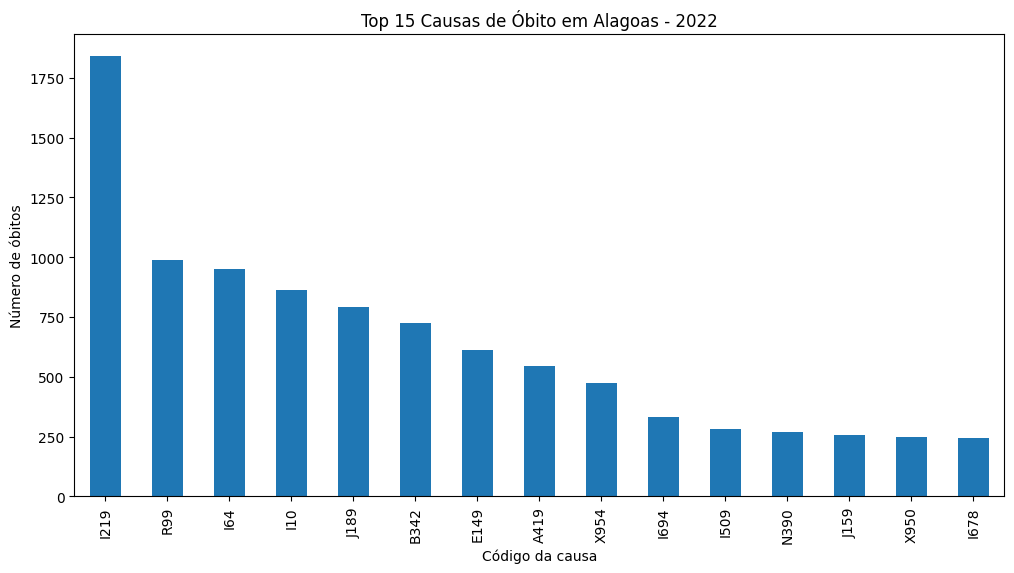

In [33]:
# Contagem das causas de óbito mais comuns
causas = df_alagoas['CAUSABAS'].value_counts().head(15)

plt.figure(figsize=(12,6))
causas.plot(kind='bar')
plt.title('Top 15 Causas de Óbito em Alagoas - 2022')
plt.ylabel('Número de óbitos')
plt.xlabel('Código da causa')
plt.show()


##### Distribuição por faixa etária (IDADE)

In [38]:
print(sorted(df_alagoas['IDADE'].unique()))
print(df_alagoas['IDADE'].value_counts().head(20))


[np.int64(1), np.int64(2), np.int64(5), np.int64(9), np.int64(10), np.int64(13), np.int64(15), np.int64(17), np.int64(19), np.int64(20), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(39), np.int64(40), np.int64(43), np.int64(44), np.int64(45), np.int64(47), np.int64(52), np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109), np.int64(110), np.int64(111), np.int64(112), np.int64(113), np.int64(114), np.int64(116), np.int64(117), np.int64(118), np.int64(120), np.int64(121), np.int64(122), np.int64(123), np.int64(200), np.int64(201), np.int64(202), np.int64(203), np.int64(204), np.int64(205), np.int64(206), np.int64(207), np.int64(208), np.int64(209), np.int64(210), np.int64(211), np.int64(212), np.int64(214), np.int64(215), np.int64(216), np.int64(217), np.int64(218), np.int64(219), np.int64(220), np.int64(221), np.int64(222), np.int64(223), np.int64(224), np.int64(225), np.i

In [39]:
def map_faixa_etaria(codigo):
    if pd.isna(codigo):
        return 'Ignorado'
    c = int(codigo)
    if c <= 130:
        return f"{c} anos"
    elif 130 <= c < 150:
        meses = c - 130
        return f"{meses} meses"
    elif 150 <= c < 180:
        dias = c - 150
        return f"{dias} dias"
    elif 200 <= c < 300:
        # Exemplo simplificado: 200 = 0-1 ano, 201 = 1-4 anos, etc.
        faixas = {
            200: '0-1 ano',
            201: '1-4 anos',
            202: '5-9 anos',
            # adicionar mais se precisar
        }
        return faixas.get(c, 'Faixa infantil desconhecida')
    elif 400 <= c < 500:
        # Exemplo simplificado para adultos e idosos
        faixas = {
            474: '60-64 anos',
            475: '65-69 anos',
            476: '70-74 anos',
            477: '75-79 anos',
            478: '80-84 anos',
            479: '85-89 anos',
            480: '90-94 anos',
            481: '95-99 anos',
            482: '100-104 anos',
            483: '105-109 anos',
            484: '110+ anos',
            # mais se precisar
        }
        return faixas.get(c, 'Faixa adulta desconhecida')
    elif c == 999:
        return 'Ignorado'
    else:
        return 'Outro código'

# Aplicar no DataFrame
df_alagoas['FAIXA_ETARIA'] = df_alagoas['IDADE'].apply(map_faixa_etaria)

# Visualizar as faixas mais comuns
print(df_alagoas['FAIXA_ETARIA'].value_counts().head(20))


FAIXA_ETARIA
Faixa adulta desconhecida      16768
60-64 anos                       549
75-79 anos                       539
100-104 anos                     537
80-84 anos                       532
95-99 anos                       491
65-69 anos                       486
Outro código                     469
70-74 anos                       458
85-89 anos                       458
90-94 anos                       442
110+ anos                        429
105-109 anos                     415
Faixa infantil desconhecida      163
1-4 anos                          46
5-9 anos                          43
101 anos                          22
104 anos                          16
102 anos                          11
103 anos                          10
Name: count, dtype: int64


count    7475.000000
mean       76.103612
std        22.640652
min         0.500000
25%        57.000000
50%        77.000000
75%        97.000000
max       112.000000
Name: IDADE_MEDIA, dtype: float64


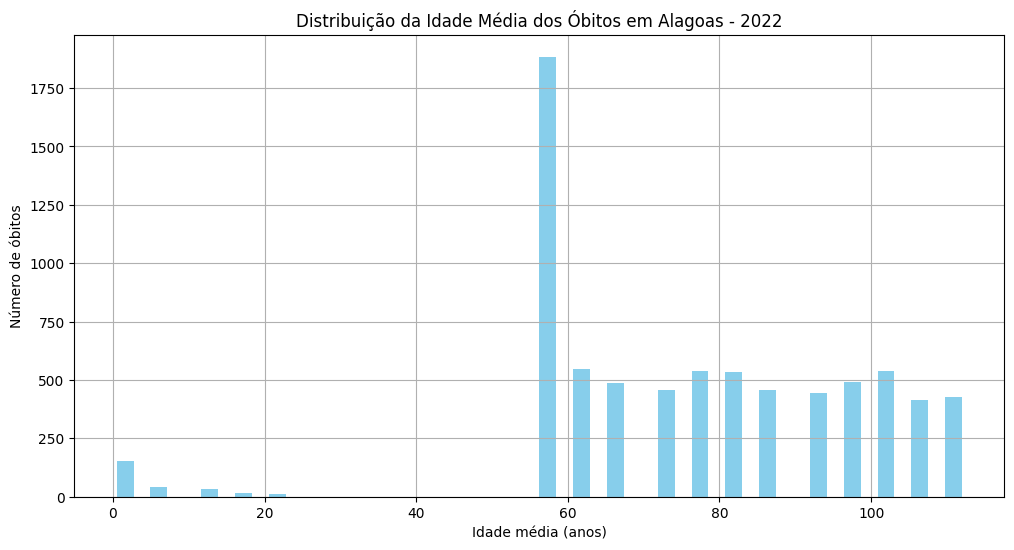

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Função para mapear faixa etária
def map_faixa_etaria(codigo):
    if pd.isna(codigo):
        return 'Ignorado'
    c = int(codigo)
    if c <= 130:
        return f"{c} anos"
    elif 130 <= c < 150:
        meses = c - 130
        return f"{meses} meses"
    elif 150 <= c < 180:
        dias = c - 150
        return f"{dias} dias"
    elif 200 <= c < 300:
        faixas_infantis = {
            200: '0-1 ano',
            201: '1-4 anos',
            202: '5-9 anos',
            203: '10-14 anos',
            204: '15-19 anos',
            205: '20-24 anos',
            # Pode adicionar mais faixas conforme necessidade
        }
        return faixas_infantis.get(c, 'Faixa infantil desconhecida')
    elif 400 <= c < 500:
        faixas_adultas = {
            470: '55-59 anos',
            471: '55-59 anos',
            472: '55-59 anos',
            473: '55-59 anos',
            474: '60-64 anos',
            475: '65-69 anos',
            476: '70-74 anos',
            477: '75-79 anos',
            478: '80-84 anos',
            479: '85-89 anos',
            480: '90-94 anos',
            481: '95-99 anos',
            482: '100-104 anos',
            483: '105-109 anos',
            484: '110+ anos',
            # Adicione mais faixas se houver
        }
        return faixas_adultas.get(c, 'Faixa adulta desconhecida')
    elif c == 999:
        return 'Ignorado'
    else:
        return 'Outro código'

# Aplicar o mapeamento
df_alagoas['FAIXA_ETARIA'] = df_alagoas['IDADE'].apply(map_faixa_etaria)

# Mapeamento para idades médias numéricas
media_idades = {
    '60-64 anos': 62,
    '65-69 anos': 67,
    '70-74 anos': 72,
    '75-79 anos': 77,
    '80-84 anos': 82,
    '85-89 anos': 87,
    '90-94 anos': 92,
    '95-99 anos': 97,
    '100-104 anos': 102,
    '105-109 anos': 107,
    '110+ anos': 112,
    '55-59 anos': 57,
    '0-1 ano': 0.5,
    '1-4 anos': 2.5,
    '5-9 anos': 7,
    '10-14 anos': 12,
    '15-19 anos': 17,
    '20-24 anos': 22,
    'Ignorado': None,
    'Faixa infantil desconhecida': 1,
    'Faixa adulta desconhecida': None,
    'Outro código': None,
}

df_alagoas['IDADE_MEDIA'] = df_alagoas['FAIXA_ETARIA'].map(media_idades)

# Visualizar estatísticas da idade média
print(df_alagoas['IDADE_MEDIA'].describe())

# Plotar histograma da idade média (ignorando valores nulos)
plt.figure(figsize=(12,6))
df_alagoas['IDADE_MEDIA'].dropna().hist(bins=50, color='skyblue')
plt.title('Distribuição da Idade Média dos Óbitos em Alagoas - 2022')
plt.xlabel('Idade média (anos)')
plt.ylabel('Número de óbitos')
plt.show()


##### Distribuição por sexo (SEXO)

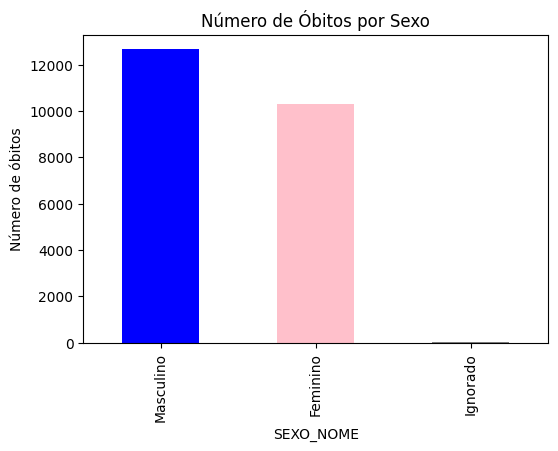

In [35]:
sexo_map = {1: 'Masculino', 2: 'Feminino', 9: 'Ignorado'}
df_alagoas['SEXO_NOME'] = df_alagoas['SEXO'].map(sexo_map).fillna('Ignorado')

plt.figure(figsize=(6,4))
df_alagoas['SEXO_NOME'].value_counts().plot(kind='bar', color=['blue', 'pink', 'gray'])
plt.title('Número de Óbitos por Sexo')
plt.ylabel('Número de óbitos')
plt.show()


##### Óbitos por município (CODMUNNATU)

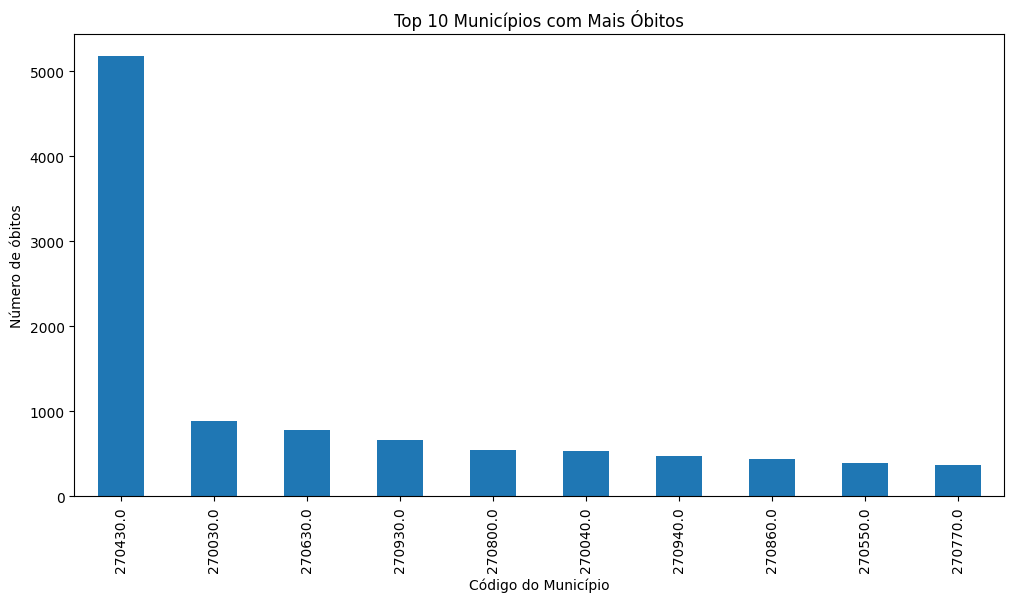

In [36]:
top_municipios = df_alagoas['CODMUNNATU'].value_counts().head(10)

plt.figure(figsize=(12,6))
top_municipios.plot(kind='bar')
plt.title('Top 10 Municípios com Mais Óbitos')
plt.xlabel('Código do Município')
plt.ylabel('Número de óbitos')
plt.show()


In [46]:
# 1. Carregar arquivo de nascidos vivos
df_nascimentos = pd.read_csv('nascidos_vivos_alagoas_2022.csv')

# Criar coluna CODMUN com os 6 primeiros caracteres (código município)
df_nascimentos['CODMUN'] = df_nascimentos['Município'].str[:6]

# 2. Filtrar óbitos infantis (idade < 130)
df_infantil = df_alagoas.loc[df_alagoas['IDADE'] < 130].copy()

# 3. Criar coluna de código município como string, 6 dígitos com zeros à esquerda
df_infantil.loc[:, 'CODMUNNATU_str'] = df_infantil['CODMUNNATU'].astype(int).astype(str).str.zfill(6)

# 4. Agrupar óbitos infantis por município e causa
obitos_por_causa = df_infantil.groupby(['CODMUNNATU_str', 'CAUSABAS']).size().reset_index(name='Qtd_Obitos')

# 5. Agrupar total óbitos infantis por município
total_obitos_infantis = df_infantil.groupby('CODMUNNATU_str').size().reset_index(name='Total_Obitos_Infantis')

# 6. Merge dos dados de nascimentos com total de óbitos infantis por município
df_mortalidade = pd.merge(
    df_nascimentos,
    total_obitos_infantis,
    left_on='CODMUN',
    right_on='CODMUNNATU_str',
    how='left'
)

# Remover coluna auxiliar usada no merge
if 'CODMUNNATU_str' in df_mortalidade.columns:
    df_mortalidade.drop(columns=['CODMUNNATU_str'], inplace=True)

# Preencher NaNs da coluna 'Total_Obitos_Infantis' com zero e converter para inteiro
df_mortalidade.loc[:, 'Total_Obitos_Infantis'] = df_mortalidade['Total_Obitos_Infantis'].fillna(0).astype(int)

# Mostrar as primeiras linhas do dataframe final
print(df_mortalidade.head())


                       Município  Nascimentos_Residencia_Mae  CODMUN  \
0             270010 AGUA BRANCA                         260  270010   
1                  270020 ANADIA                         184  270020   
2               270030 ARAPIRACA                        3673  270030   
3                 270040 ATALAIA                         537  270040   
4  270050 BARRA DE SANTO ANTONIO                         289  270050   

   Total_Obitos_Infantis  
0                    0.0  
1                    0.0  
2                    3.0  
3                    1.0  
4                    0.0  


#### Regressão com RandomForestRegressor

In [50]:
# Modelo de regressão
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Avaliação
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - RMSE: {rmse_rf:.2f}")
print(f"Random Forest Regressor - R²: {r2_rf:.2f}")


Random Forest Regressor - RMSE: 1.38
Random Forest Regressor - R²: 0.40


#### Classificação binária (óbito infantil ocorreu ou não)

In [63]:
# 1. Carregar dados
df_nascimentos = pd.read_csv('nascidos_vivos_alagoas_2022.csv')
df_nascimentos['CODMUN'] = df_nascimentos['Município'].str[:6]

df_infantil = df_alagoas[df_alagoas['IDADE'] < 130].copy()
df_infantil['CODMUNNATU_str'] = df_infantil['CODMUNNATU'].astype(int).astype(str).str.zfill(6)

# 2. Preparar features e agrupar
features_usar = ['IDADE', 'SEXO', 'RACACOR', 'ESCMAE2010', 'PARTO', 'PESO']
df_features = df_infantil[features_usar + ['CODMUNNATU_str']].copy()

for col in ['SEXO', 'RACACOR', 'ESCMAE2010', 'PARTO']:
    df_features[col] = df_features[col].astype(str)

df_grouped = df_features.groupby('CODMUNNATU_str').agg({
    'IDADE': 'mean',
    'PESO': 'mean',
    'SEXO': lambda x: x.value_counts(normalize=True).to_dict(),
    'RACACOR': lambda x: x.value_counts(normalize=True).to_dict(),
    'ESCMAE2010': lambda x: x.value_counts(normalize=True).to_dict(),
    'PARTO': lambda x: x.value_counts(normalize=True).to_dict(),
}).reset_index()

# Expandir dicionários em colunas
df_grouped = df_grouped.join(df_grouped.pop('SEXO').apply(pd.Series).add_prefix('SEXO_'))
df_grouped = df_grouped.join(df_grouped.pop('RACACOR').apply(pd.Series).add_prefix('RACACOR_'))
df_grouped = df_grouped.join(df_grouped.pop('ESCMAE2010').apply(pd.Series).add_prefix('ESCMAE2010_'))
df_grouped = df_grouped.join(df_grouped.pop('PARTO').apply(pd.Series).add_prefix('PARTO_'))

# 3. Total de óbitos infantis por município
obitos_por_mun = df_infantil.groupby('CODMUNNATU_str').size().reset_index(name='Total_Obitos_Infantis')

# 4. Merge com nascimentos e óbitos
df_merged = pd.merge(df_nascimentos, df_grouped, left_on='CODMUN', right_on='CODMUNNATU_str', how='left')
df_merged = pd.merge(df_merged, obitos_por_mun, left_on='CODMUN', right_on='CODMUNNATU_str', how='left')

df_merged['Total_Obitos_Infantis'] = df_merged['Total_Obitos_Infantis'].fillna(0)
df_merged['Obito_Infantil'] = (df_merged['Total_Obitos_Infantis'] > 0).astype(int)

# 5. Preparar dados para o modelo removendo colunas que podem vazar a resposta
cols_para_remover = [
    'Município', 'CODMUN', 'CODMUNNATU_str_x', 'CODMUNNATU_str_y', 'Total_Obitos_Infantis'
]
df_modelo = df_merged.drop(columns=cols_para_remover)
df_modelo = df_modelo.fillna(0)

X = df_modelo.drop(columns='Obito_Infantil')
y = df_modelo['Obito_Infantil']

print("Distribuição das classes antes do balanceamento:")
print(y.value_counts(normalize=True))

# 6. Balancear classes com SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("\nDistribuição das classes após SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

# 7. Separar treino/teste com stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# 8. Pipeline + GridSearch para RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("\nMelhores parâmetros:", grid.best_params_)

# 9. Avaliar modelo no hold-out
y_pred = grid.predict(X_test)
print("\nHold-out Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 10. Validação cruzada com melhor modelo
best_clf = grid.best_estimator_
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_clf, X_res, y_res, cv=cv, scoring='accuracy')
print("\nCross-Validation Accuracy Média:", np.round(scores.mean(), 3))
print("Todas as acurácias por fold:", np.round(scores, 3))

# 11. Feature importances
importances = best_clf.named_steps['clf'].feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features por importância:")
print(feat_importances.head(10))


Distribuição das classes antes do balanceamento:
Obito_Infantil
0    0.825243
1    0.174757
Name: proportion, dtype: float64

Distribuição das classes após SMOTE:
Obito_Infantil
0    0.5
1    0.5
Name: proportion, dtype: float64

Melhores parâmetros: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}

Hold-out Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        17

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

Confusion Matrix:
 [[17  0]
 [ 0 17]]

Cross-Validation Accuracy Média: 1.0
Todas as acurácias por fold: [1. 1. 1. 1. 1.]

Top 10 features por importância:
PESO                          0.307271
PARTO_1.0                     0.203420
IDADE                         0.122297
ESCMAE2010_3.0       

#### Código interativo para simulação de mortalidade infantil em 2025

In [67]:
# Função para gerar dados simulados 2025 com parâmetros dinâmicos
def simular_predicao(idade_media=28.0, peso_medio=3200, parto_1=0.7, sexo_1=0.48):
    # Exemplo simplificado com 5 municípios fixos
    dados_2025 = {
        'CODMUN': ['270010', '270020', '270030', '270040', '270050'],
        'IDADE': [idade_media]*5,
        'PESO': [peso_medio]*5,
        'SEXO_1': [sexo_1]*5,
        'SEXO_2': [1 - sexo_1]*5,
        'RACACOR_1.0': [0.1]*5,
        'RACACOR_2.0': [0.3]*5,
        'RACACOR_3.0': [0.6]*5,
        'ESCMAE2010_1.0': [0.3]*5,
        'ESCMAE2010_2.0': [0.4]*5,
        'ESCMAE2010_3.0': [0.3]*5,
        'PARTO_1.0': [parto_1]*5,
        'PARTO_2.0': [1 - parto_1]*5,
        'Nascimentos_Residencia_Mae': [260, 184, 3673, 537, 289],
    }
    df_2025 = pd.DataFrame(dados_2025)

    # Obter as colunas que o modelo foi treinado
    colunas_treino = list(X.columns)  # 'X' é o DataFrame de treino usado na construção do modelo

    # Criar as colunas faltantes com zeros para evitar erros no modelo
    for col in colunas_treino:
        if col not in df_2025.columns:
            df_2025[col] = 0

    # Reordenar as colunas para coincidir com a ordem do treino
    df_2025 = df_2025[colunas_treino]

    # Prever com modelo treinado clf
    prob_obito = clf.predict_proba(df_2025)[:, 1]
    classes_pred = clf.predict(df_2025)

    df_2025['Prob_Obito_Infantil'] = prob_obito
    df_2025['Predicao_Obito_Infantil'] = classes_pred

    # Mostrar tabela com resultados
    display(df_2025[['Prob_Obito_Infantil', 'Predicao_Obito_Infantil']])

    # Plotar gráfico
    plt.figure(figsize=(10,6))
    plt.bar(dados_2025['CODMUN'], df_2025['Prob_Obito_Infantil'], color='skyblue')
    plt.title('Probabilidade Prevista de Óbito Infantil por Município - 2025')
    plt.xlabel('Código Município')
    plt.ylabel('Probabilidade de Óbito Infantil')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Interação com sliders para ajustar valores
interact(
    simular_predicao,
    idade_media=FloatSlider(min=18, max=40, step=0.5, value=28, description='Idade Média'),
    peso_medio=IntSlider(min=2000, max=4500, step=50, value=3200, description='Peso Médio (g)'),
    parto_1=FloatSlider(min=0, max=1, step=0.05, value=0.7, description='Parto Tipo 1'),
    sexo_1=FloatSlider(min=0, max=1, step=0.01, value=0.48, description='Proporção Sexo 1')
)

interactive(children=(FloatSlider(value=28.0, description='Idade Média', max=40.0, min=18.0, step=0.5), IntSli…

<function __main__.simular_predicao(idade_media=28.0, peso_medio=3200, parto_1=0.7, sexo_1=0.48)>